# Анализ временного ряда

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import mean_squared_error

In [2]:
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv

--2025-03-27 10:27:00--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2180 (2.1K) [text/plain]
Saving to: ‘airline-passengers.csv’

airline-passengers. 100%[===================>]   2.13K  --.-KB/s    in 0s      

2025-03-27 10:27:00 (19.8 MB/s) - ‘airline-passengers.csv’ saved [2180/2180]



In [32]:
df = pd.read_csv("airline-passengers.csv")
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


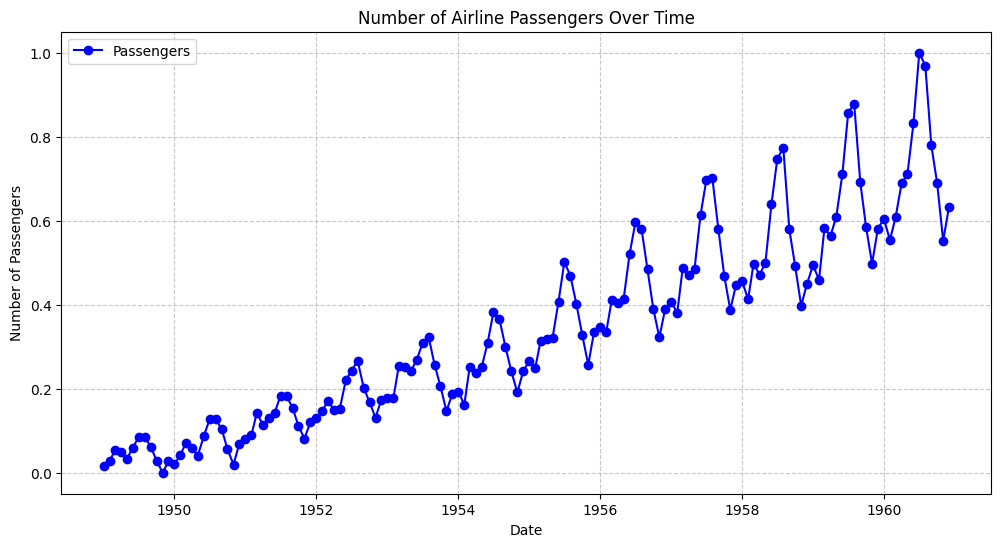

In [38]:
df['Month'] = pd.to_datetime(df['Month'])

plt.figure(figsize=(12, 6))
plt.plot(df['Month'], df['Passengers'], marker='o', color='b', label='Passengers')
plt.title('Number of Airline Passengers Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

### 1) Предобработка данных

In [39]:
scaler = MinMaxScaler()
df['Passengers'] = scaler.fit_transform(df[['Passengers']])
data = df['Passengers'].values

### 2) Создание датасета

In [43]:
def create_sequences(data, seq_length):
  X, y = [], []
  for i in range(len(data) - seq_length):
    X.append(data[i:i + seq_length])
    y.append(data[i + seq_length])
  return np.array(X), np.array(y)

seq_length = 25
X, y = create_sequences(data, seq_length)
X = np.expand_dims(X, axis=1)

train_size = int(len(X) * 0.8)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1)

print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')

X_train shape: torch.Size([95, 1, 25]), y_train shape: torch.Size([95, 1])


### 3) Создание нейронной сети

In [44]:
class TimeSeriesCNN(nn.Module):
    def __init__(self):
        super(TimeSeriesCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=2)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 5, 50)
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


### 4) Обучение модели

In [45]:
model = TimeSeriesCNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50
batch_size = 32

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    loss.backward()
    optimizer.step()

print('✅ Обучение завершено!')

✅ Обучение завершено!


### 5) Оценка и прогнозирование

RMSE: 0.17


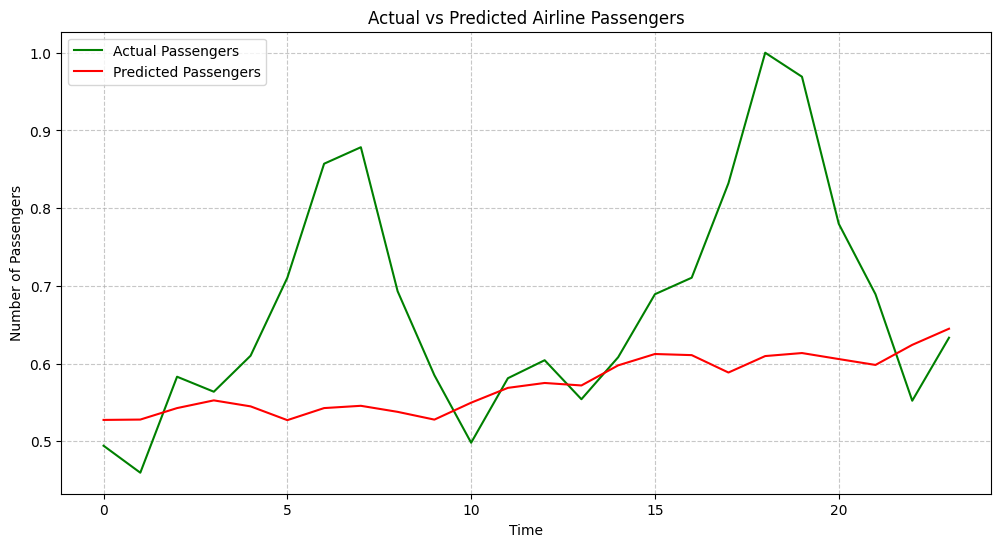

In [46]:
model.eval()
with torch.no_grad():
    predictions = model(X_test).numpy()

predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.numpy())

rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
print(f'RMSE: {rmse:.2f}')

plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Passengers', color='g')
plt.plot(predictions, label='Predicted Passengers', color='r')
plt.title('Actual vs Predicted Airline Passengers')
plt.xlabel('Time')
plt.ylabel('Number of Passengers')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()